# Lokalizacja punktu na płaszczyźnie dwuwymiarowej – metoda trapezowa 

### Treść zadania

Dany jest obszar z podziałem poligonowym. Zadawany jest punkt P na płaszczyźnie. Należy
zaimplementować algorytm lokalizacji punktu metodą trapezową, który odpowie na pytanie,
w którym elemencie znajduje się dany punkt. (Należy także umożliwić użytkownikowi
odpowiednio zadawanie obszaru z podziałem poligonowym.) 
Zrobić analizę efektywności algorytmu.

Program powinien w sposób graficzny prezentować etapy algorytmu dla wybranych
przykładów (w celu objaśnienia działania algorytmu). Program ma służyć jako narzędzie
dydaktyczne do objaśnienia działania algorytmu. 

### Realizacja projektu

### Dane:
Poligonowy podział płaszczyzny oraz punkt P należący do zadanej płaszczyzny.

### Cel:
Odszukanie wielokąta (ściany) zawierającego zadany punkt w czasie optymalnym -> $O(nlogn)$.

#### Uwaga: 
Istnieją ustawienia, które nie pozwolą nam jednoznacznie wskazać, do którego wielokąta możemy przypisać punkt P (nie będzie on leżał wewnątrz żadnej ze ścian). W celu pokrycia takiego przypadku brzegowego, umieszczamy cały podział w prostokącie zawierającym całą płaszczynę planarną. Prosotkąt ten będzie nazywać $B$. W wypadku wystąpienia wcześniej opsianego przypadku brzegowego, algorytm zwróci obszar opisanego prostokąta $B$.


## Metoda trapezowa
Podział płaszczyzny będzie reprezentowany przez zbiór odcinków $S$ = {$s$<sub>1</sub>,$s$<sub>2</sub>,...,$s$<sub>n</sub>}, o następujących założeniach:
- wartości współrzędnej x początku i końca odcinka dla żadnego odcinka nie są takie same, innymi słowy zbiór nie zawiera odcników pionowych,
- żadne dwa odcinki nie przecinają się, poza ewentualnie nachodzącymi na siebie wierzchołkami,
- wierzchołki żadnych dwóch odcinków nie mają takiej samej współrzędnej x (poza ewentualnymi końcami połączonych odcinków).

W celu realizacji algorytmu wprowadzimy nową strukturę odpowiedzialną za reprezentację płaszczyzny - Mapę trapezową.
### Mapa trapezowa
Mapa trapezowa $T$($S$) jest podziałem $S$ na trapezy (prawidłowe lub zdegenerowane) otrzymanym przez poprowadzenie dwóch odcinków pionowych z każdego końca odcinka w $S$. Rozszerzenia kończą się, gdy napotkają inny odcinek $S$ lub brzeg prostokąta $B$. 

### Wykorzystywane struktury danych

Oprócz wskazanej wcześniej struktury Mapy tapezowej, implementację uzupełniono o realizację opartą o następujących strukturach

### Point

Struktura odpowiedzialna za obsługę pojedynczych punktów i ich informacji

In [85]:
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def get_x(self):
        return self.x
    
    def get_y(self):
        return self.y
    
    def __gt__(self, other):
        return self.x > other.x

    def to_tuple(self):
        return (self.x, self.y)

    def __str__(self):
        return "{},{}".format(self.x, self.y)
    
    def __hash__(self):
        return hash((self.x, self.y))

### Segment

Struktura odpowiedzialna za przetrzymywanie informacji o pojedyncznym odcinku na płaszczyźnie

In [277]:
class Segment:
    x = 0  # Default value instead of None
    
    def __init__(self, point1, point2):
        if point1.x < point2.x:
            self.left = point1
            self.right = point2
        else:
            self.left = point2
            self.right = point1
            
        self.a = None
        self.b = None
        self._calculate_line_parameters()
        
    def _calculate_line_parameters(self):
        dx = self.right.x - self.left.x
        if dx != 0: 
            self.a = (self.right.y - self.left.y) / dx
            self.b = self.left.y - (self.a * self.left.x)
        else:
            # Handle vertical lines
            self.a = float('inf')
            self.b = self.left.x

    @classmethod
    def set_reference_x(cls, x):
        cls.x = x

    def get_y(self, x):
        if self.left.x <= x <= self.right.x:
            if self.a is not None:
                if self.a == float('inf'):
                    return None  # Vertical line
                return self.a * x + self.b
        return None
    
    def get_a(self):
        return self.a
    
    def get_b(self):
        return self.b
    
    def is_above(self, point):
        y_at_x = self.get_y(point.x)
        return y_at_x is not None and point.y > y_at_x

    def __lt__(self, other):
        if not isinstance(other, Segment):
            return NotImplemented
        if self.a is None or other.a is None:
            return False
        if self.a == float('inf') or other.a == float('inf'):
            return self.b < other.b
        y_self = self.get_y(Segment.x)
        y_other = other.get_y(Segment.x)
        if y_self is None or y_other is None:
            return False
        return y_self < y_other

    def __gt__(self, other):
        if not isinstance(other, Segment):
            return NotImplemented
        if self.a is None or other.a is None:
            return False
        if self.a == float('inf') or other.a == float('inf'):
            return self.b > other.b
        y_self = self.get_y(Segment.x)
        y_other = other.get_y(Segment.x)
        if y_self is None or y_other is None:
            return False
        return y_self > y_other

    def __hash__(self):
        return hash((self.left, self.right))
    
    def to_tuple(self):
        return (self.left.to_tuple(), self.right.to_tuple())
    
    def __eq__(self, other):
        if not isinstance(other, Segment):
            return False
        return self.left == other.left and self.right == other.right

    @staticmethod
    def update_x(x):
        Segment.x = x

    def isAbove(self, point):
        return self.is_above(point)  # Use the existing is_above method

### Trapez

Przechowuje pojedynczy odcinek należący do mapy tapezów

In [87]:
class Trapez:
    def __init__(self, top, bottom, p, q):
        self.top_segment = top
        self.bottom_segment = bottom
        self.left_point = p
        self.right_point = q

        self.top_left = None
        self.bottom_left = None
        self.top_right = None
        self.bottom_right = None
        self.node = None

    def __str__(self):
        return f"{self.bottom_segment} {self.top_segment}"
    
    def __eq__(self, other):
        if not isinstance(other, Trapez):
            return False
        return (self.top_segment == other.top_segment and 
                self.bottom_segment == other.bottom_segment and
                self.left_point == other.left_point and 
                self.right_point == other.right_point)

    def copy(self):
        new_trapez = Trapez(
            self.top_segment,
            self.bottom_segment,
            self.left_point,
            self.right_point
        )
        new_trapez.update_neighbors(
            self.top_left,
            self.top_right,
            self.bottom_left,
            self.bottom_right
        )
        new_trapez.node = self.node
        return new_trapez
    
    def split_at_point(self, point):
        if not self.left_point.x <= point.x <= self.right_point.x:
            return None, None
            
        left_trapez = Trapez(
            self.top_segment,
            self.bottom_segment,
            self.left_point,
            point
        )
        
        right_trapez = Trapez(
            self.top_segment,
            self.bottom_segment,
            point,
            self.right_point
        )
        
        return left_trapez, right_trapez

### Rectangle

Prostokąt otoczający całą płąszczyznę 

In [88]:
class Rectangle:
    @staticmethod
    def create_rectangle(lines):
        x_coords = [point[0] for line in lines for point in line]
        y_coords = [point[1] for line in lines for point in line]

        min_x = min(x_coords)
        max_x = max(x_coords)
        min_y = min(y_coords)
        max_y = max(y_coords)

        low_left = Point(min_x, min_y)
        low_right = Point(max_x, min_y)
        up_left = Point(min_x, max_y)
        up_right = Point(max_x, max_y)

        top_segment = Segment(up_left, up_right)
        bottom_segment = Segment(low_left, low_right)

        return Trapez(top_segment, bottom_segment, up_left, up_right)

<span style="color:red">ogranac co sie dzieje w tych drzewach </span>

### Drzewa

Zaimplementowo dwie strultury drzew, podstawową - Node i specjalnie przygotowaną do tego algorytmu - Tree
Nasze rozważania skupimy na tej drugiej
<p>Tree - Struktura umożliwiająca przeszukiwanie mapy trapezowej w celu znalezienia "ściany" do której należy zadany punkt.</p>
<p>Zawiera ona 3 typy węzłów:</p>
<ul>
    <li>l_type_node - jest to liść drzewa, który zawiera jedną ze "ścian" mapy trapezowej</li>
    <li>x_type_node - jest to węzeł typu X zawierający punkt</li>
    <li>y_type_node - jest to węzeł typu Y zawierający odcinek</li>
</ul>

In [89]:
class Node:
    def __init__(self, node_type, data):
        self.node_type = node_type
        self.data = data
        self.left = None
        self.right = None

In [221]:
class Tree:
    def __init__(self, root):
        self.root = root

    def update_root(self, root):
        self.root = root

    def search(self, node, point, segment=None):
        if node.node_type == 'l_type_node':
            return node.data
            
        if node.node_type == 'x_type_node':
            next_node = node.left if point.x < node.data.x else node.right
        else:
            if node.data.is_above(point):
                next_node = node.left
            elif node.data.get_y(point.x) == point.y:
                next_node = node.left if segment.a > node.data.a else node.right
            else:
                next_node = node.right
                
        return self.search(next_node, point, segment)
    
    def query(self, node, point, segment=None):
        if node.node_type == 'l_type_node':
            return node.data
        if node.node_type == 'x_type_node':
            if point < node.data:
                return self.query(node.left, point, segment)
            else:
                return self.query(node.right, point, segment)
        else:
            if node.data.isAbove(point):
                return self.query(node.left, point, segment)
            elif node.data.get_y(point.x) == point.y:
                if segment.a > node.data.a:
                    return self.query(node.left, point, segment)
                else:
                    return self.query(node.right, point, segment)
            else:
                return self.query(node.right, point, segment)



    @staticmethod
    def update_node_both_sides(trapezoid, segment, left, top, bottom, right):
        node = trapezoid.node
        node.node_type = 'x_type_node'
        node.data = segment.left

        lefl_type_node = Node('l_type_node', left)
        node.left = lefl_type_node
        left.node = lefl_type_node

        righl_type_node = Node('x_type_node', segment.right)
        node.right = righl_type_node

        right_leaf = Node('l_type_node', right)
        righl_type_node.right = right_leaf
        right.node = right_leaf

        segmenl_type_node = Node('y_type_node', segment)
        righl_type_node.left = segmenl_type_node

        top_leaf = Node('l_type_node', top)
        segmenl_type_node.left = top_leaf
        top.node = top_leaf

        bottom_leaf = Node('l_type_node', bottom)
        segmenl_type_node.right = bottom_leaf
        bottom.node = bottom_leaf

    @staticmethod
    def update_node_right_side(trapezoid, segment, top, bottom, right):
        node = trapezoid.node
        node.node_type = 'x_type_node'
        node.data = segment.right

        right_leaf = Node('l_type_node', right)
        node.right = right_leaf
        right.node = right_leaf

        segmenl_type_node = Node('y_type_node', segment)
        node.left = segmenl_type_node

        top_leaf = Node('l_type_node', top)
        segmenl_type_node.left = top_leaf
        top.node = top_leaf

        bottom_leaf = Node('l_type_node', bottom)
        segmenl_type_node.right = bottom_leaf
        bottom.node = bottom_leaf

    @staticmethod
    def update_node_left_side(trapezoid, segment, left, top, bottom):
        node = trapezoid.node
        node.node_type = 'x_type_node'
        node.data = segment.left

        lefl_type_node = Node('l_type_node', left)
        node.left = lefl_type_node
        left.node = lefl_type_node

        segmenl_type_node = Node('y_type_node', segment)
        node.right = segmenl_type_node

        bottom_leaf = Node('l_type_node', bottom)
        segmenl_type_node.right = bottom_leaf
        bottom.node = bottom_leaf

        top_leaf = Node('l_type_node', top)
        segmenl_type_node.left = top_leaf
        top.node = top_leaf

    @staticmethod
    def update_node_no_sides(trapezoid, segment, top, bottom):
        node = trapezoid.node
        node.node_type = 'y_type_node'
        node.data = segment

        top_leaf = Node('l_type_node', top)
        node.left = top_leaf
        top.node = top_leaf

        bottom_leaf = Node('l_type_node', bottom)
        node.right = bottom_leaf
        bottom.node = bottom_leaf

    @staticmethod
    def update_node_multiple(trapezoids, segment, new_above, new_below, left, right):
        
        if left:
            Tree.update_node_left_side(trapezoids[0], segment, left, new_above[0], new_below[0])
        
        else:
            Tree.update_node_no_sides(trapezoids[0], segment, new_above[0], new_below[0])

        node = trapezoids[0].node
        i, j = 0, 0
        
        while i + j < len(trapezoids) - 2:
            
            node = trapezoids[i + j + 1].node
            node.node_type = 'y_type_node'
            node.data = segment

            if i == len(new_above) - 1 or (j < len(new_below) - 1 and new_below[j].right_point < new_above[i].right_point):
                j += 1
                above_node = new_above[i].node
                below_leaf = Node('l_type_node', new_below[j])
                node.left = above_node
                node.right = below_leaf
                new_below[j].node = below_leaf
            
            else:
                i += 1
                below_node = new_below[j].node
                above_leaf = Node('l_type_node', new_above[i])
                node.right = below_node
                node.left = above_leaf
                new_above[i].node = above_leaf

        lasl_type_node = trapezoids[-1].node
        
        if right:
            lasl_type_node.node_type = 'x_type_node'
            lasl_type_node.data = segment.right
            right_leaf = Node('l_type_node', right)
            lasl_type_node.right = right_leaf
            right.node = right_leaf
            segmenl_type_node = Node('y_type_node', segment)
            lasl_type_node.left = segmenl_type_node
        
        else:
            lasl_type_node.node_type = 'y_type_node'
            lasl_type_node.data = segment

        last_above = new_above[-1].node
        last_below = new_below[-1].node
        
        if i == len(new_above) - 1 and j == len(new_below) - 1:
            lasl_type_node.left = last_above
            lasl_type_node.right = last_below
        
        elif j == len(new_below) - 1:
            last_above_leaf = Node('l_type_node', new_above[-1])
            lasl_type_node.left = last_above_leaf
            new_above[-1].node = last_above_leaf
            lasl_type_node.right = last_below
        
        else:
            last_below_leaf = Node('l_type_node', new_below[-1])
            lasl_type_node.right = last_below_leaf
            new_below[-1].node = last_below_leaf
            lasl_type_node.left = last_above


### TrapezoidMap

Tworzenie mapy i operacje na niej

In [140]:
import random
class TrapezoidMap:

    def __init__(self):
      self.tree = None

    def insertIntoOne(_, trapezoid : Trapez, segment : Segment):
        p, q = segment.left, segment.right
        bottom_left = trapezoid.bottom_left
        bottom_right = trapezoid.bottom_right
        top_left = trapezoid.top_left
        top_right = trapezoid.top_right
        
        left, right = None, None
        top = Trapez(trapezoid.top_segment, segment, p, q)
        bottom = Trapez(segment, trapezoid.bottom_segment, p, q)
        
        if trapezoid.left_point < p:
            left = Trapez(trapezoid.top_segment, trapezoid.bottom_segment, trapezoid.left_point, p)
            left.bottom_left = bottom_left
            left.top_left = top_left

            if trapezoid.top_left: trapezoid.top_left.top_right = left
            if trapezoid.bottom_left: trapezoid.bottom_left.bottom_right = left

            left.top_right = top
            left.bottom_right = bottom
            top.top_left = left
            bottom.bottom_left = left
  


        else:
            Segment.update_x(p.x)
            bottom.bottom_left = bottom_left
            top.top_left = top_left
            if bottom_left:
                bottom_left.bottom_right = bottom
                if bottom_left.top_segment > segment:
                    bottom_left.top_right = top
                    top.bottom_left = bottom_left
            if top_left:
                top_left.top_right = top
                if segment > top_left.bottom_segment:
                    top_left.bottom_right = bottom
                    bottom.top_left = top_left
                    
        if trapezoid.right_point > q:
            right = Trapez(trapezoid.top_segment, trapezoid.bottom_segment, segment.right, trapezoid.right_point)
            right.bottom_right = bottom_right
            right.top_right = top_right
            right.bottom_left = bottom
            right.top_left = top
            top.top_right = right
            bottom.bottom_right = right
            if trapezoid.top_right: trapezoid.top_right.top_left = right
            if trapezoid.bottom_right: trapezoid.bottom_right.bottom_left = right
        else:
            Segment.update_x(q.x)
            bottom.bottom_right = bottom_right
            top.top_right = top_right
            if bottom_right:
                bottom_right.bottom_left = bottom
                if bottom_right.top_segment > segment:
                    bottom_right.top_left = top
                    top.bottom_right = bottom_right
            if top_right:
                top_right.top_left = top
                if segment > top_right.bottom_segment:
                    top_right.bottom_left = bottom
                    bottom.top_right = top_right
                    
        if left and right:
            Tree.update_node_both_sides(trapezoid, segment, left, top, bottom, right)
        elif not left and right:
            Tree.update_node_right_side(trapezoid, segment, top, bottom, right)
        elif left and not right:
            Tree.update_node_left_side(trapezoid, segment, left, top, bottom)
        else:
            Tree.update_node_no_sides(trapezoid, segment, top, bottom)
    def insertIntoMany (_, trapezoids: list[Trapez], segment: Segment):
        p, q = segment.left, segment.right
        left, right = None, None
        newTrapezoidsAbove = []
        newTrapezoidsBelow = []
        n = len(trapezoids)
        first = trapezoids[0]
        bottom_left = first.bottom_left
        top_left = first.top_left
        top_right = first.top_right
        bottom_right = first.bottom_right
        Segment.update_x(first.right_point.x)
        
        if segment.is_above(first.right_point):
            top = Trapez(first.top_segment, segment, p, first.right_point)
            bottom = Trapez(segment, first.bottom_segment, p, Point(Segment.x, segment.get_y(Segment.x)))
            merge = "lower"
        else:
            top = Trapez(first.top_segment, segment, p, Point(Segment.x, segment.get_y(Segment.x)))
            bottom = Trapez(segment, first.bottom_segment, p, first.right_point)
            merge = "upper"
            
        if first.left_point < p:
            left = Trapez(first.top_segment, first.bottom_segment, first.left_point, p)
            left.bottom_left = bottom_left
            left.top_left = top_left
            left.top_right = top
            left.bottom_right = bottom
            top.top_left = left
            bottom.bottom_left = left 
            if first.top_left: first.top_left.top_right = left
            if first.bottom_left: first.bottom_left.bottom_right = left
            
            
        else:           
            bottom.bottom_left = bottom_left
            top.top_left = top_left
            if bottom_left:
                bottom_left.bottom_rightt = bottom
                if bottom_left.top_segment > segment:
                    bottom_left.top_right = top
                    top.bottom_left = bottom_left
            if top_left:
                top_left.top_right = top
                if segment > top_left.bottom_segment:
                    top_left.bottom_right = bottom
                    bottom.top_left = top_left
                                
        if trapezoids[1] == first.bottom_right:
            top.top_right = top_right
            if top_right:
                top_right.top_left = top
        else:
            bottom.bottom_right = bottom_right
            if bottom_right:
                bottom_right.bottom_left = bottom
        
        newTrapezoidsAbove.append(top)
        newTrapezoidsBelow.append(bottom)
        
        for i in range(1, n-1):
            nextPoint = trapezoids[i].right_point
            bottom_left = trapezoids[i].bottom_left
            top_left = trapezoids[i].top_left
            top_right = trapezoids[i].top_right
            bottom_right = trapezoids[i].bottom_right
            Segment.update_x(nextPoint.x)
            
            if segment.is_above(nextPoint):
                lowerright_point = Point(Segment.x, segment.get_y(Segment.x))
                if merge == "upper":
                    top.right_point = nextPoint
                    t = Trapez(segment, trapezoids[i].bottom_segment, bottom.right_point, lowerright_point)
                    bottom.top_right = t
                    t.top_left = bottom
                    t.bottom_left = bottom_left
                    if bottom_left:
                        bottom_left.bottom_right = t
                    top.top_right = top_right
                    if top_right:
                        top_right.top_left = top
                    bottom = t
                    newTrapezoidsBelow.append(bottom)
                else:
                    bottom.right_point = lowerright_point
                    t = Trapez(trapezoids[i].top_segment, segment, top.right_point, nextPoint)
                    top.bottom_right = t
                    t.bottom_left = top
                    t.top_left = top_left
                    t.top_right = top_right
                    if top_left:
                        top_left.top_right = t
                    if top_right:
                        top_right.top_left = t
                    top = t
                    newTrapezoidsAbove.append(top)
                merge = "lower"   
            else:
                upperright_point = Point(Segment.x, segment.get_y(Segment.x))
                if merge == "upper":
                    top.right_point = upperright_point
                    t = Trapez(segment, trapezoids[i].bottom_segment, bottom.right_point, nextPoint)
                    bottom.top_right = t
                    t.top_left = bottom
                    t.bottom_left = bottom_left
                    t.bottom_right = bottom_right
                    if bottom_left:
                        bottom_left.bottom_right = t
                    if bottom_right:
                        bottom_right.bottom_left = t
                    bottom = t
                    newTrapezoidsBelow.append(bottom)
                else:
                    bottom.right_point = nextPoint
                    t = Trapez(trapezoids[i].top_segment, segment, top.right_point, upperright_point)
                    top.bottom_right = t
                    t.bottom_left = top
                    t.top_left = top_left
                    if top_left:
                        top_left.top_right = t
                    bottom.bottom_right = bottom_right
                    if bottom_right:
                        bottom_right.bottom_left = bottom
                    top = t
                    newTrapezoidsAbove.append(top)
                merge="upper"
                
        last = trapezoids[n-1]
        bottom_left = last.bottom_left
        top_left = last.top_left
        top_right = last.top_right
        bottom_right = last.bottom_right
        Segment.update_x(last.right_point)
            
        if merge == "upper":
            top.right_point = q
            t = Trapez(segment, last.bottom_segment, bottom.right_point, q)
            bottom.top_right = t
            t.top_left = bottom
            bottom = t
            newTrapezoidsBelow.append(bottom)
        else:
            bottom.right_point = q
            t = Trapez(last.top_segment, segment, top.right_point, q)
            top.bottom_right = t
            t.bottom_left = top
            top = t
            newTrapezoidsAbove.append(top)
            
        if last.right_point > q:
            right = Trapez(last.top_segment, last.bottom_segment, q, last.right_point)
            right.bottom_left = bottom
            right.top_left = top
            right.top_right = top_right
            right.bottom_right = bottom_right
            top.top_right = right
            bottom.bottom_right = right
            if last.top_right: last.top_right.top_left = right
            if last.bottom_right: last.bottom_right.bottom_left = right
        else:
            top.top_right = top_right
            bottom.bottom_right = bottom_right
            if bottom_right:
                bottom_right.bottom_left = bottom
                if bottom_right.top_segment > segment:
                    bottom_right.top_left = top
                    top.bottom_right = bottom_right
            if top_right:
                top_right.top_left = top
                if segment > top_right.bottom_segment:
                    top_right.bottom_left = bottom
                    bottom.top_right = top_right
                    
        if last == trapezoids[n-2].top_right:
            bottom.bottom_left = bottom_left
            if bottom_left:
                bottom_left.bottom_right = bottom
        else:
            top.top_left = top_left
            if top_left:
                top_left.top_right = top
                
        Tree.update_node_multiple(trapezoids, segment, newTrapezoidsAbove, newTrapezoidsBelow, left, right)

## Algorytmy
Aby rozwiązać zadany problem zaimplementowano poniższe algorytmy i funckje pomocnicze
### Randomizowany algorytm przyrostowy
Przetwarzamy odcinki ze zbioru  S  w dowolnej permutacji. Dla niektórych przypadków otrzymana struktura przeszukiwań  Tree może mieć rozmiar kwadratowy i liniowy czas przeszukiwania, ale dla innych permutacji złożoności tych operacji będą znacznie korzystniejsze. Analiza złożoności tego algorytmu jest probabilistyczna. Jak się okazuje, oczekiwana złożoność czasowa konstrukcji mapy trapezowej to  O(n log n) , oczekiwany rozmiar struktury przeszukiwań to  O(n) , natomiast oczekiwany czas zapytania dla dowolnego punktu to O(log n) , gdzie  n  oznacza liczbę odcinków ze zbioru  S , dla którego tę strukturę przygotowujemy.


In [173]:
def create_trapezoidal_map(segments):
        S = []    
        for i in random.sample(segments, len(segments)):    
            p1 = Point(i[0][0], i[0][1])
            p2 = Point(i[1][0], i[1][1])
            S.append(Segment(p1, p2))
        
        R = Rectangle.create_rectangle(segments)
        rool_type_node = Node('l_type_node', R)
        T = Tree(rool_type_node)
        R.node = rool_type_node
        
        for segment in S:
            p, q = segment.left, segment.right
            Segment.update_x(p.x)
            trapezoids = []
            trapezoid_zero = T.query(T.root, p, segment)
            trapezoids.append(trapezoid_zero)
            i = 0
            while q > trapezoids[i].right_point:
                Segment.update_x(trapezoids[i].right_point.x)
                if not segment.is_above(trapezoids[i].right_point):
                    trapezoids.append(trapezoids[i].top_right)
                else:
                    trapezoids.append(trapezoids[i].bottom_right)
                i += 1
                
            if len(trapezoids) == 1:
                TrapezoidMap.insertIntoOne(T, trapezoids[0], segment)
            else:
                TrapezoidMap.insertIntoMany(T, trapezoids, segment)   
        return T

In [174]:
import random
import numpy as np

<h1><span style="color:red">Dotąd jest aktualnie zmienione</span></h1>

## Tworzenie mapy trapezowej wraz z wizualizacją
Najpierw rozważymy wcześniej przygotowane zbiory realizujące zbiory testowe

In [222]:
from bitalg.visualizer.main import Visualizer

def trapezoidal_map_vis(segments):
    S = []
    scenes = []

    start = Visualizer()
    start.add_line_segment(segments, color="green")
    scenes.append(start)

    for i in random.sample(segments, len(segments)):
        p1 = Point(i[0][0], i[0][1])
        p2 = Point(i[1][0], i[1][1])
        S.append(Segment(p1, p2))

    R = Rectangle.create_rectangle(segments)
    rool_type_node = Node('l_type_node', R)
    R.node = rool_type_node
    T = Tree(rool_type_node)
    
    
    vis = draw_map(T, R)
    scenes.append(vis)
    for segment in S:
        vis = draw_map(T,R)
        vis.add_line_segment(segment.to_tuple())
        scenes.append(vis)

        p, q = segment.left, segment.right
        Segment.update_x(p.x)
        intersectedTrapezoids = []
        trapezoid_zero = T.query(T.root, p, segment)
        intersectedTrapezoids.append(trapezoid_zero)
        i = 0
        while intersectedTrapezoids[i] is not None and q > intersectedTrapezoids[i].right_point:
            Segment.update_x(intersectedTrapezoids[i].right_point.x)
            if not segment.is_above(intersectedTrapezoids[i].right_point):
                intersectedTrapezoids.append(intersectedTrapezoids[i].top_right)
            else:
                intersectedTrapezoids.append(intersectedTrapezoids[i].bottom_right)
            i += 1
        intersects = draw_map(T, R)
        intersects.add_line_segment(segment.to_tuple(), color="red")
        for trap in intersectedTrapezoids:
            intersects = draw_trapezoid_query(trap,intersects,color="purple")
        scenes.append(intersects)

        if len(intersectedTrapezoids) == 1:
            TrapezoidMap.insertIntoOne(T, intersectedTrapezoids[0], segment)
        else:
            TrapezoidMap.insertIntoMany(T, intersectedTrapezoids, segment)

        vis = draw_map(T, R)
        scenes.append(vis)

    return T, scenes


def findPointVisualised(lines, point: Point):
    T, scenes = trapezoidal_map_vis(lines)
    B = Rectangle.create_rectangle(lines)
    trap = T.query(T.root, point)
    vis = draw_map(T, B)
    vis.add_point(point.to_tuple(), color="red")
    vis = draw_trapezoid_query(trap, vis)
    vis.show()


def draw_map(T,B):
    vis = Visualizer()
    trapezoids = []
    find_all_trapezoids(T.root, trapezoids)
    for trapezoid in trapezoids:
        vis = draw_trapezoid(trapezoid, vis)

    vis = draw_grid(B, vis)
    return vis


def find_all_trapezoids(node, trapezoids):
    if node.node_type == 'l_type_node':
        trapezoids.append(node.data)
    else:
        find_all_trapezoids(node.left, trapezoids)
        find_all_trapezoids(node.right, trapezoids)


def draw_grid(R: Trapez, vis):
    vis.add_line_segment((R.top_segment.to_tuple(), R.bottom_segment.to_tuple()), color="brown")
    R_left = Segment(R.bottom_segment.left, Point(R.left_point.x, R.right_point.y))
    R_right = Segment(Point(R.right_point.x, R.left_point.y), R.bottom_segment.right)
    vis.add_line_segment((R_left.to_tuple(), R_right.to_tuple()), color="brown")
    return vis


def draw_trapezoid(trapezoid: Trapez,vis,color="green"):

    upper = trapezoid.top_segment.to_tuple()
    lower = trapezoid.bottom_segment.to_tuple()
    currentX=trapezoid.left_point.x
    Segment.update_x(currentX)

    leftBottom=(currentX, trapezoid.bottom_segment.get_y(currentX))
    leftTop=(currentX, trapezoid.top_segment.get_y(currentX))
    leftBound=(leftBottom, leftTop)

    currentX = trapezoid.right_point.x
    Segment.update_x(currentX)
    rightBottom = (currentX, trapezoid.bottom_segment.get_y(currentX))
    rightTop = (currentX, trapezoid.top_segment.get_y(currentX))
    rightBound = (rightBottom, rightTop)

    vis.add_point((leftBottom, leftTop, rightBottom, rightTop), color="darkgreen")
    vis.add_line_segment((upper, lower, leftBound, rightBound), color=color)
    vis.add_point((trapezoid.left_point.to_tuple(), trapezoid.right_point.to_tuple()), color="blue")
    return vis


def draw_trapezoid_query(trapezoid: Trapez, vis: Visualizer, color="red"):
    currentX = trapezoid.left_point.x
    Segment.update_x(currentX)

    leftBottom=(currentX, trapezoid.bottom_segment.get_y(currentX))
    leftTop=(currentX, trapezoid.top_segment.get_y(currentX))
    leftBound=(leftBottom, leftTop)

    currentX = trapezoid.right_point.x
    Segment.update_x(currentX)
    rightBottom = (currentX, trapezoid.bottom_segment.get_y(currentX))
    rightTop = (currentX, trapezoid.top_segment.get_y(currentX))
    rightBound = (rightBottom, rightTop)

    lower = (leftBottom, rightBottom)
    upper = (leftTop, rightTop)

    vis.add_point((leftBottom, leftTop, rightBottom, rightTop), color="purple")
    vis.add_line_segment((upper, lower, leftBound, rightBound), color=color)
    vis.add_point((trapezoid.left_point.to_tuple(), trapezoid.right_point.to_tuple()), color="purple")
    return vis

In [223]:
import matplotlib.pyplot as plt
from matplotlib.widgets import Button
import tkinter as tk

class Presenter:
    def __init__(self, scenes):
        self.scenes = []
        self.scene_data = []
        for vis in scenes:
            data, plot_data = vis.getData()
            self.scenes.append(data)
            self.scene_data.append(plot_data)

        self.i = len(self.scenes) - 1

        plt.subplots_adjust(bottom=0.2)

    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.05, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.25, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.prev)
        return [b_prev, b_next]

    def draw(self):
        self.ax.clear()
        for figure in self.scenes[self.i]:
            figure.draw(self.ax)
        self.ax.autoscale()
        plt.draw()

    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw()

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw()

    def set_axes(self, ax):
        self.ax = ax

    def display(self):
        plt.close()
        fig = plt.figure()
        self.widgets = self.__configure_buttons()
        self.ax = plt.axes(autoscale_on=False)

        plt.show()
        self.draw()

In [298]:
from Examples import *

In [286]:
%matplotlib tk
T1, scenes1 = trapezoidal_map_vis(exampleLines1)
pr1 = Presenter(scenes1)
pr1.display()

In [287]:
%matplotlib tk
T2, scenes2 = trapezoidal_map_vis(exampleLines2)
pr2 = Presenter(scenes2)
pr2.display()

In [288]:
%matplotlib tk
T3, scenes3 = trapezoidal_map_vis(exampleLines3)
pr3 = Presenter(scenes3)
pr3.display()

In [28]:
%matplotlib tk
T4, scenes4 = trapezoidal_map_vis(exampleLines4)
pr4 = Presenter(scenes4)
pr4.display()

In [296]:
%matplotlib tk
T5, scenes5 = trapezoidal_map_vis(exampleLines5)
pr5 = Presenter(scenes5)
pr5.display()

<span style="color:red">To nie działa, jutro to zmienie, mam napisaną już funckje do tego w osobnym pilku</span>

In [300]:
Lines6 = [((5.120967741935484, 6.607142857142858), (2.5604838709677415, 4.307359307359308)),
           ((2.5604838709677415, 4.307359307359308), (6.975806451612902, 1.25)),
             ((6.975806451612902, 1.25), (5.766129032258064, 9.71861471861472)),
               ((5.766129032258064, 9.71861471861472), (5.120967741935484, 6.607142857142858)),
                 ((5.766129032258064, 9.71861471861472), (8.407258064516128, 3.495670995670996)),
                   ((8.407258064516128, 3.495670995670996), (6.975806451612902, 1.25)),
                     ((6.975806451612902, 1.25), (5.766129032258064, 9.71861471861472)),
                       ((8.407258064516128, 3.495670995670996), (7.338709677419354, 4.848484848484849)), 
                       ((7.338709677419354, 4.848484848484849), (7.157258064516128, 3.874458874458875)), 
                       ((7.157258064516128, 3.874458874458875), (7.076612903225806, 3.0357142857142856)), 
                       ((7.076612903225806, 3.0357142857142856), (7.641129032258064, 2.9274891774891776)),
                         ((7.641129032258064, 2.9274891774891776), (8.407258064516128, 3.495670995670996)), 
                         ((8.407258064516128, 3.495670995670996), (5.766129032258064, 9.71861471861472)), 
                         ((5.766129032258064, 9.71861471861472), (8.608870967741934, 9.44805194805195)), 
                         ((8.608870967741934, 9.44805194805195), (8.407258064516128, 3.495670995670996)),
                           ((5.120967741935484, 6.607142857142858), (1.6129032258064515, 9.745670995670997)), 
                           ((1.6129032258064515, 9.745670995670997), (0.463709677419355, 1.304112554112554)),
                             ((0.463709677419355, 1.304112554112554), (2.3991935483870965, 1.0335497835497836)),
                               ((2.3991935483870965, 1.0335497835497836), (1.431451612903226, 2.8733766233766236)), 
                               ((1.431451612903226, 2.8733766233766236), (1.875, 6.201298701298702)), 
                               ((1.875, 6.201298701298702), (2.5604838709677415, 4.307359307359308)), 
                               ((2.5604838709677415, 4.307359307359308), (5.120967741935484, 6.607142857142858)),
                                 ((2.3991935483870965, 1.0335497835497836), (2.5604838709677415, 4.307359307359308)),
                                   ((2.5604838709677415, 4.307359307359308), (1.431451612903226, 2.8733766233766236)),
                                     ((1.431451612903226, 2.8733766233766236), (2.3991935483870965, 1.0335497835497836)),
                                       ((1.431451612903226, 2.8733766233766236), (1.875, 6.201298701298702)), 
                                       ((1.875, 6.201298701298702), (2.5604838709677415, 4.307359307359308)), 
                                       ((2.5604838709677415, 4.307359307359308), (1.431451612903226, 2.8733766233766236))]

In [351]:
%matplotlib tk
#print(y)
T6, scenes6 = trapezoidal_map_vis(y)
pr6 = Presenter(scenes6)
pr6.display()

In [265]:
def convert_to_line_segments(polygons):
        """
        Konwertuje wielokąty na format listy krotek z parami punktów float.
        Przykład: [((x1, y1), (x2, y2)), ...]
        """
        segments = []
        for polygon in polygons:
            # Domknij wielokąt
            polygon = polygon + [polygon[0]]
            # Utwórz odcinki
            for i in range(len(polygon)-1):
                segment = (
                    (float(polygon[i][0]), float(polygon[i][1])),
                    (float(polygon[i+1][0]), float(polygon[i+1][1]))
                )
                segments.append(segment)
        return segments

In [266]:
import matplotlib
matplotlib.use('TkAgg')
from matplotlib.widgets import PolygonSelector
import matplotlib.pyplot as plt
import numpy as np

def add_polygons():
    """
    Funkcja umożliwia dodawanie wielu wielokątów z automatycznym przyciąganiem
    punktów w trakcie rysowania, zarówno do punktów aktualnego wielokąta,
    jak i wszystkich poprzednich. 'n' - nowy wielokąt, 'q' - zakończ.
    """
    polygons = []  # Lista przechowująca wszystkie wielokąty
    current_points = []  # Lista punktów aktualnie rysowanego wielokąta
    all_points = []  # Lista wszystkich istniejących punktów we wszystkich wielokątach
    snap_radius = 0.5  # Promień przyciągania do punktów
    
    def snap_to_existing(x, y):
        """
        Przyciąga punkt (x, y) do istniejących punktów ze wszystkich wielokątów,
        jeśli znajduje się w ich pobliżu.
        """
        # Połącz punkty z aktualnego wielokąta i wszystkich poprzednich
        points_to_check = all_points + current_points
        
        for px, py in points_to_check:
            if np.sqrt((x - px) ** 2 + (y - py) ** 2) <= snap_radius:
                return px, py
        return x, y

    def on_select(verts):
        """
        Funkcja wywoływana po zakończeniu zaznaczania wielokąta.
        """
        nonlocal current_points
        # Przyciągnij wszystkie wierzchołki do istniejących punktów
        snapped_verts = [snap_to_existing(v[0], v[1]) for v in verts]
        polygons.append(snapped_verts)
        
        # Dodaj punkty do listy wszystkich punktów
        all_points.extend(snapped_verts)
        
        # Wyczyść punkty aktualnego wielokąta
        current_points = []
        
        # Narysuj wszystkie wielokąty
        ax.clear()
        ax.set_title("Zaznacz wielokąt. 'n' - nowy wielokąt, 'q' - zakończ.")
        ax.set_xlim(0, 10)
        ax.set_ylim(0, 10)
        
        # Rysuj wszystkie zapisane wielokąty
        for poly in polygons:
            poly_array = np.array(poly)
            ax.fill(poly_array[:, 0], poly_array[:, 1], alpha=0.3)
            ax.plot(poly_array[:, 0], poly_array[:, 1], 'o-')
        
        plt.draw()
        print(f"Dodano wielokąt: {polygons[-1]}")

    def on_move_callback(verts):
        """
        Wywoływane podczas rysowania wielokąta, modyfikuje punkty w czasie rzeczywistym.
        """
        nonlocal current_points
        current_points = []  # Wyczyść aktualną listę punktów
        
        for i, (x, y) in enumerate(verts):
            snapped_x, snapped_y = snap_to_existing(x, y)
            verts[i] = (snapped_x, snapped_y)
            current_points.append((snapped_x, snapped_y))

    def on_key(event):
        nonlocal polygon_selector, current_points
        if event.key == 'q':
            print("Zakończono dodawanie wielokątów.")
            plt.close(fig)
        elif event.key == 'n':
            print("Rozpoczęcie nowego wielokąta.")
            current_points = []  # Wyczyść punkty aktualnego wielokąta
            polygon_selector.disconnect_events()
            polygon_selector = PolygonSelector(ax, on_select, useblit=True)
            polygon_selector.onmove = on_move_callback

    # Inicjalizacja wykresu
    fig, ax = plt.subplots()
    ax.set_title("Zaznacz wielokąt. 'n' - nowy wielokąt, 'q' - zakończ.")
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)

    # Pierwszy selector z obsługą przesuwania
    polygon_selector = PolygonSelector(ax, on_select, useblit=True)
    polygon_selector.onmove = on_move_callback

    # Nasłuchiwanie zdarzeń klawiatury
    fig.canvas.mpl_connect('key_press_event', on_key)

    plt.show(block=True)
    return convert_to_line_segments(polygons)

In [ ]:
x = add_polygons()


In [348]:
import matplotlib.pyplot as plt
from matplotlib.widgets import Button, TextBox
import json
import os
import tkinter as tk
from tkinter import filedialog
%matplotlib tk

all_sets_of_segments = []
current_set_of_segments = []
current_segment = []
input_mode = False  
limits_mode = False 

initial_xlim = [-100, 100]
initial_ylim = [-100, 100]
current_xlim = initial_xlim[:]
current_ylim = initial_ylim[:]

def draw_interactive_segments():
    global current_xlim, current_ylim, current_segment, current_set_of_segments

    ax.cla() 

    if len(current_segment) == 2:
        current_set_of_segments.append(current_segment[:])
        current_segment = []

    if current_segment:
        x, y = zip(*current_segment)
        ax.plot(x, y, 'ro-', markersize=5, label='Current Segment')

    for segment in current_set_of_segments:
        if len(segment) == 2:
            x, y = zip(*segment)
            ax.plot(x, y, 'bo-', markersize=5, label='Completed Segment')

    ax.set_title(" ")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")

    ax.set_xlim(current_xlim)
    ax.set_ylim(current_ylim)

    plt.draw()

def on_click(event):
    if event.button == 1 and event.inaxes and not input_mode and not limits_mode:
        current_segment.append((event.xdata, event.ydata))
        draw_interactive_segments()

def add_point_from_input(event=None):
    global current_xlim, current_ylim
    if input_mode and not limits_mode:
        try:
            x = float(text_box_x.text)
            y = float(text_box_y.text)
            current_segment.append((x, y))
            
            x_margin = 0.1 * (current_xlim[1] - current_xlim[0]) 
            y_margin = 0.1 * (current_ylim[1] - current_ylim[0])
            
            if x < current_xlim[0]:
                current_xlim[0] = x - x_margin
            if x > current_xlim[1]:
                current_xlim[1] = x + x_margin
            if y < current_ylim[0]:
                current_ylim[0] = y - y_margin
            if y > current_ylim[1]:
                current_ylim[1] = y + y_margin
            
            draw_interactive_segments()
        except ValueError:
            print("Invalid coordinates.")

def on_key(event):
    global input_mode, limits_mode, current_segment, current_set_of_segments
    if event.key == 's':
        save_polygon()
    elif event.key == 'b':
        if (current_set_of_segments or current_segment) and not input_mode and not limits_mode:
            if current_segment:
                current_segment.clear()
            else:
                current_set_of_segments.pop()
            draw_interactive_segments()
    elif event.key == 'i': 
        toggle_input_mode()
    elif event.key == 'c': 
        clear_polygon()

def toggle_input_mode(event=None):
    global input_mode
    input_mode = not input_mode
    update_input_mode_display()

def update_input_mode_display():
    if input_mode:
        input_mode_display.label.set_text("Input Mode: ON")
    else:
        input_mode_display.label.set_text("Input Mode: OFF")

    plt.draw()

def save_polygon():
    if not current_set_of_segments:
        print("No points to save.")
        return
    if current_segment:
        print("Improper point left.")
        return

    root = tk.Tk()
    root.withdraw()

    json_filepath = filedialog.asksaveasfilename(
        defaultextension=".json",
        filetypes=[("JSON files", ".json"), ("All files", ".*")],
        initialdir=".",
        title="Save Polygon As JSON"
    )

    if json_filepath:
        with open(json_filepath, "w") as file:
            all_sets_of_segments.append(current_set_of_segments[:])
            json.dump(current_set_of_segments, file)
        print(f"Saved polygon to file {json_filepath}")
    else:
        print("Save operation was cancelled.")

def clear_polygon(event=None):
    global current_set_of_segments, current_xlim, current_ylim
    if not input_mode and not limits_mode:
        current_set_of_segments.clear() 
        current_segment.clear()
        
     
        current_xlim = initial_xlim[:]
        current_ylim = initial_ylim[:]
        
        draw_interactive_segments()

def get_segments_as_tuples():
    """Zwraca listę krotek współrzędnych odcinków."""
    segments = []
    for segment in current_set_of_segments:
        for point in segment:
            segments.append(tuple(point))  # Konwertuje każdą parę punktów na krotkę
    return segments

# Przyklad jak uzyskać dane:
# print(get_segments_as_tuples())  # To zwróci listę krotek współrzędnych odcinków

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim(initial_xlim)
ax.set_ylim(initial_ylim)
plt.draw()


fig.canvas.mpl_connect('button_press_event', on_click)

fig.canvas.mpl_connect('key_press_event', on_key)

ax_edit_mode = fig.add_axes([0.04, 0.75, 0.2, 0.05])
input_mode_display = Button(ax_edit_mode, 'Input Mode: OFF')
input_mode_display.on_clicked(toggle_input_mode)

ax_text_x = fig.add_axes([0.04, 0.70, 0.2, 0.05])
text_box_x = TextBox(ax_text_x, 'X:', initial="0")

ax_text_y = fig.add_axes([0.04, 0.65, 0.2, 0.05])
text_box_y = TextBox(ax_text_y, 'Y:', initial="0")

ax_add_point = fig.add_axes([0.04, 0.60, 0.2, 0.05])
btn_add_point = Button(ax_add_point, 'Add Point')
btn_add_point.on_clicked(add_point_from_input)

fig.canvas.mpl_connect('button_press_event', on_click)
fig.canvas.mpl_connect('key_press_event', on_key)

draw_interactive_segments()
plt.show(block=True)


y = get_segments_as_tuples() 
print(y)

[(np.float64(-58.98268398268398), np.float64(55.41125541125544)), (np.float64(21.10389610389612), np.float64(59.74025974025977)), (np.float64(-63.85281385281385), np.float64(25.108225108225128)), (np.float64(28.13852813852816), np.float64(18.61471861471864)), (np.float64(-51.94805194805194), np.float64(-33.87445887445887)), (np.float64(84.41558441558448), np.float64(-27.38095238095238)), (np.float64(-31.926406926406912), np.float64(-65.25974025974025)), (np.float64(53.03030303030306), np.float64(-70.12987012987013))]


In [349]:
import numpy as np

def convert_to_float_tuples(segments):
    result = []
    
    # Iterujemy przez każdy segment (segmenty mają postać ((x1, y1), (x2, y2)))
    for i in range(0, len(segments), 2):
        # Zamiast konwertować całą krotkę, konwertujemy tylko wartości x i y
        segment = (
            (float(segments[i][0]), float(segments[i][1])),  # Pierwszy punkt
            (float(segments[i+1][0]), float(segments[i+1][1]))  # Drugi punkt
        )
        result.append(segment)
    
    return result

y = convert_to_float_tuples(y)
print(y)

[((-58.98268398268398, 55.41125541125544), (21.10389610389612, 59.74025974025977)), ((-63.85281385281385, 25.108225108225128), (28.13852813852816, 18.61471861471864)), ((-51.94805194805194, -33.87445887445887), (84.41558441558448, -27.38095238095238)), ((-31.926406926406912, -65.25974025974025), (53.03030303030306, -70.12987012987013))]


In [350]:
#print(x)
P = Point(4.5,5.5)
findPointVisualised(y, P)

In [291]:
T, scenes = trapezoidal_map_vis([((np.float64(5.221774193548386), np.float64(2.8733766233766236)), (np.float64(7.379032258064516), np.float64(2.4404761904761907))), ((np.float64(2.2379032258064515), np.float64(4.442640692640693)), (np.float64(5.806451612903226), np.float64(5.497835497835498))), ((np.float64(0.9274193548387095), np.float64(5.795454545454546)), (np.float64(7.278225806451612), np.float64(7.175324675324676))), ((np.float64(3.6491935483870965), np.float64(8.7987012987013)), (np.float64(9.637096774193548), np.float64(5.1190476190476195)))])
pr = Presenter(scenes)
pr.display()

AttributeError: 'NoneType' object has no attribute 'left_point'

## Wizualizacja 
Poniżej przykładowe wizualizacje szukania najmniejszego trapezu zawierającego zadany punkt

<span style="color:red">Zmienić zbiory albo przynajmniej kolejność</span>

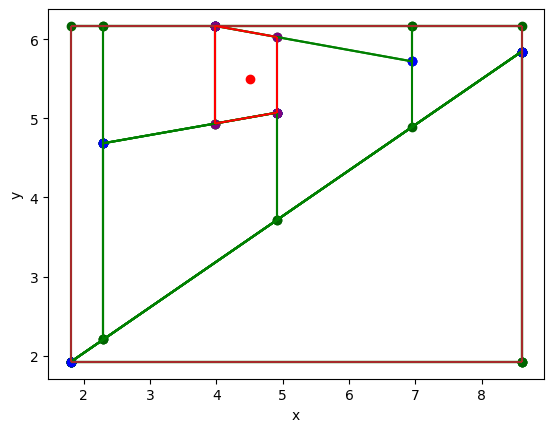

In [279]:
%matplotlib inline
  # to dziala
P = Point(4.5,5.5)
findPointVisualised(exampleLines1, P)

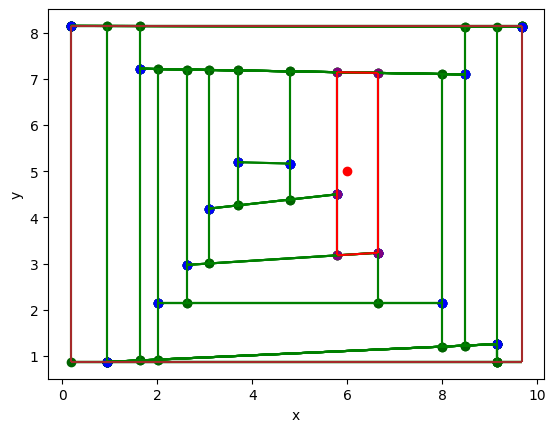

In [128]:
%matplotlib inline
P = Point(6,5)
# to dziala 4/5
findPointVisualised(exampleLines2, P)

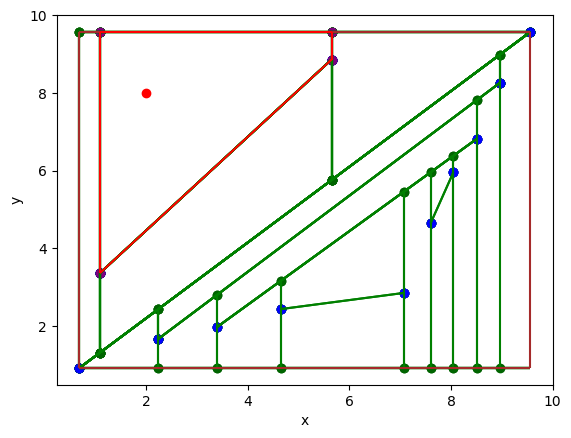

In [133]:
%matplotlib inline
P = Point(2,8)
# to dziala
findPointVisualised(exampleLines3, P)

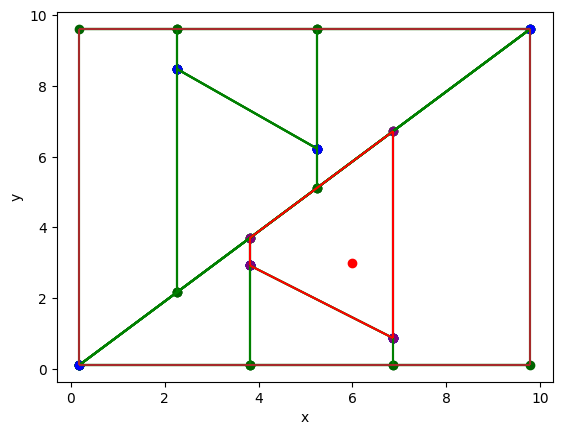

In [138]:
%matplotlib inline
P = Point(6,3)
# to dziala
findPointVisualised(exampleLines4, P)

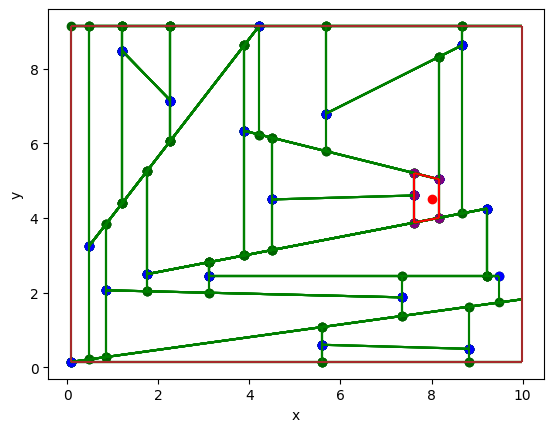

In [172]:
P = Point(8,4.5)
# to nei dziala
findPointVisualised(exampleLines5, P)

## Analiza efektywności algorytmu
### Czas konstrukcji mapy trapezowej
Przetestujemy czas budowania mapy trapezowej dla zbiorów odcinków o różnej mocy. Aby były spełnione założenia, będziemy generować równoległe odcinki o końcach w różnych współrzędnych $x$. Tutaj nie będziemy wizualizować efektu, ponieważ ze względu na dużą liczbę trapezów w tej skali nie byłoby to czytelne (ale mapa jest konstruowana prawidłowo).

In [66]:
import random
import numpy as np

In [65]:
def generateParallelSegments(maxX, maxY, n):
    divider = maxY / 2.0
    above = n // 2
    below = n - n // 2
    segments = []

    deltaX = deltaY = (maxY - divider) / (above + 1)
    for i in range(1, above + 1):
        segments.append(((i * deltaX, divider + deltaY), (maxX - i * deltaX, divider + deltaY)))

    deltaY = divider / (below + 1)
    for i in range(1, below + 1):
        segments.append((((i - 0.5) * deltaX, divider - deltaY), (maxX - (i - 0.5) * deltaX, divider - deltaY)))

    return segments

In [280]:
from time import time

sizes = [100, 500, 1000, 5000, 10000] #,50000, #75000, #100000]
x_size, y_size = 100, 100
trapezoidalMaps = []

# Służy do zapewnienia, że mapa będzie miała wystarczający rozmiar
base = [((0, 0),(x_size, 0)),((0, y_size),(x_size, y_size))] 

for n in sizes:
    segments = generateParallelSegments(x_size, y_size, n - 2)
    t1 = time()
    T = create_trapezoidal_map(segments + base)
    t2 = time()
    trapezoidalMaps.append(T)
    print("Czas budowania mapy trapezowej dla", n, "odcinków: {ex_time:.4f} s".format(ex_time = t2 - t1))

Czas budowania mapy trapezowej dla 100 odcinków: 0.0068 s
Czas budowania mapy trapezowej dla 500 odcinków: 0.0238 s
Czas budowania mapy trapezowej dla 1000 odcinków: 0.0460 s
Czas budowania mapy trapezowej dla 5000 odcinków: 0.9586 s
Czas budowania mapy trapezowej dla 10000 odcinków: 1.4637 s


### Rozmiar struktury przeszukiwań 
Jako rozmiar struktury przeszukiwań rozumiemy liczbę węzłów (wszystkich, nie tylko liści).

In [282]:
def calculate_tree_size(node, count, visited):
    if node is None or node in visited:
        return
    count[0] += 1
    visited.add(node)
    calculate_tree_size(node.left, count, visited)
    calculate_tree_size(node.right, count, visited)

In [283]:
for i in range(len(trapezoidalMaps)):
    T = trapezoidalMaps[i]
    DSize = [0]
    visited = set()
    calculate_tree_size(T.root, DSize, visited)
    print("Rozmiar struktury przeszukiwań dla", sizes[i], "odcinków:", DSize[0])

Rozmiar struktury przeszukiwań dla 100 odcinków: 602
Rozmiar struktury przeszukiwań dla 500 odcinków: 2758
Rozmiar struktury przeszukiwań dla 1000 odcinków: 5603
Rozmiar struktury przeszukiwań dla 5000 odcinków: 28598
Rozmiar struktury przeszukiwań dla 10000 odcinków: 61587


### Czas wyszukiwania trapezu dla podanego punktu w mapie trapezowej
Testy poniżej mierzą czas znajdowania różnej liczby punktów w mapach trapezowych, zbudowanych na zadanej ilości odcinków
wygenerowanych losowo i spełniających wymagania zadania.

In [284]:
def generate_uniform_points(maxX, maxY, n):
    x_coord = np.random.uniform(1, maxX, n)
    y_coord = np.random.uniform(1, maxY, n)

    res = [(x, y) for x, y in zip(x_coord, y_coord)]
    return res

In [285]:
pointCount = 100000

for i in range(len(trapezoidalMaps)):
    print(f"Test dla mapy zbudowanej z {sizes[i]} odcinków")
    T = trapezoidalMaps[i]
    points = generate_uniform_points(x_size - 1, y_size - 1, pointCount)
    P = []
    for x,y in points:
        P.append(Point(x, y))
    
    t1 = time()
    for p in P:
        T.query(T.root, p)
    t2 = time()
    print("Czas wyszukiwania dla ", pointCount, "punktów: {ex_time:.4f} s".format(ex_time = t2 - t1))

Test dla mapy zbudowanej z 100 odcinków
Czas wyszukiwania dla  100000 punktów: 0.5870 s
Test dla mapy zbudowanej z 500 odcinków
Czas wyszukiwania dla  100000 punktów: 0.9690 s
Test dla mapy zbudowanej z 1000 odcinków
Czas wyszukiwania dla  100000 punktów: 0.6995 s
Test dla mapy zbudowanej z 5000 odcinków
Czas wyszukiwania dla  100000 punktów: 1.2583 s
Test dla mapy zbudowanej z 10000 odcinków
Czas wyszukiwania dla  100000 punktów: 0.9642 s
